## Stacking the Best Models
<pre><b>This Kernel shows how the scores can be improved using Stacking Method.
Credit Goes to the following kernels
ref:
1. https://www.kaggle.com/filemide/distance-criskiev-hyparam-cont-1-662
2. https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481
3. https://www.kaggle.com/marcelotamashiro/lgb-public-kernels-plus-more-features
4. https://www.kaggle.com/scaomath/no-memory-reduction-workflow-for-each-type-lb-1-28
5. https://www.kaggle.com/fnands/1-mpnn/output?scriptVersionId=18233432
6. https://www.kaggle.com/harshit92/fork-from-kernel-1-481
7. https://www.kaggle.com/xwxw2929/keras-neural-net-and-distance-features
8. https://www.kaggle.com/marcogorelli/criskiev-s-distances-more-estimators-groupkfold?scriptVersionId=18843561
9. https://www.kaggle.com/toshik/schnet-starter-kit
10.https://www.kaggle.com/abazdyrev/nn-w-o-skew

</b></pre>

## Stat Stack

In [3]:
nb = '99-06'

In [4]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
import seaborn as sns
%matplotlib inline
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

champs-scalar-coupling



In [5]:
sub_path = './../output'
all_files = [
# 'nb60_submission_lgb_-1.5330660525700779.csv',
# 'nb79_submission_extra_trees_regressor_-1.56760.csv',
# 'nb80_submission_extra_trees_regressor_-1.48000.csv',
# 'nb81_submission_bagging_regressor_-1.44452.csv',
# 'nb84_submission_extra_trees_regressor_-1.60943.csv',
# 'nb85_submission_extra_trees_regressor_-1.52972.csv',
# 'nb88_submission_lgb_-1.547953965914086.csv',
# 'nb91_submission_extra_trees_regressor_-1.47467.csv',
# 'nb91_stack_submission_lgb_-1.7348780297791941.csv',
# 'nb95_stack_submission_ridge_-1.74195.csv',
# 'nb95_stack_submission_lasso_-1.74192.csv',
# 'nb96_stack_submission_extra_trees_regressor_-1.79030.csv',
# 'nb99_stack_submission_random_forest_regressor_-1.78717.csv',
# 'nb99-01_stack_submission_lgb_-1.75427.csv',
    
'blend_test_median.csv',
'nb99-03_blend_submission_-1.8044855761193852.csv',
'keras_newral_net_pl_-1.67.csv',
'stack_median-1.839.csv',
'stack_median-1.895.csv',
]

In [6]:
import warnings
warnings.filterwarnings("ignore")
outs = [pd.read_csv(os.path.join(sub_path, f), index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "mol" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)
concat_sub.head()
ncol = concat_sub.shape[1]

In [7]:
# check correlation
concat_sub.iloc[:,1:].corr()

,mol0,mol1,mol2,mol3,mol4
mol0,1.000000,0.999986,0.999929,0.999985,0.999984
mol1,0.999986,1.000000,0.999909,0.999972,0.999971
mol2,0.999929,0.999909,1.000000,0.999921,0.999946
mol3,0.999985,0.999972,0.999921,1.000000,0.999993
mol4,0.999984,0.999971,0.999946,0.999993,1.000000


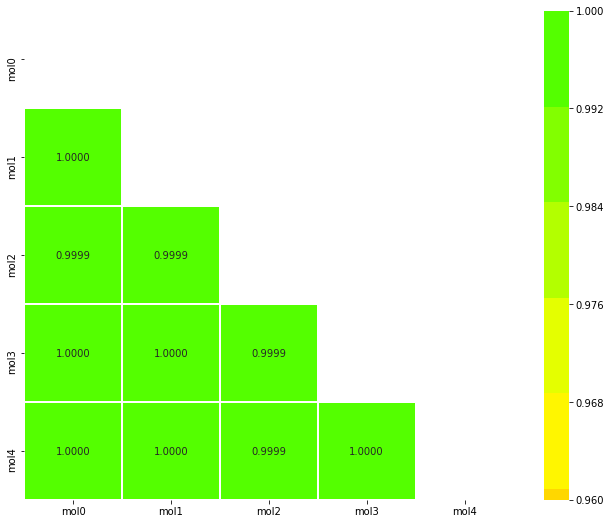

In [8]:
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='prism', vmin=0.96, center=0, square=True, linewidths=1, annot=True, fmt='.4f')

In [9]:
# get the data fields ready for stacking
concat_sub['m_max'] = concat_sub.iloc[:, 1:].max(axis=1)
concat_sub['m_min'] = concat_sub.iloc[:, 1:].min(axis=1)
concat_sub['m_median'] = concat_sub.iloc[:, 1:].median(axis=1)

In [10]:
concat_sub.describe()

,id,mol0,mol1,mol2,mol3,mol4,m_max,m_min,m_median
count,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06,2.505542e+06
mean,5.910918e+06,1.588385e+01,1.588688e+01,1.588054e+01,1.588402e+01,1.588214e+01,1.603457e+01,1.573315e+01,1.588309e+01
std,7.232878e+05,3.486571e+01,3.486612e+01,3.485870e+01,3.486948e+01,3.486402e+01,3.495479e+01,3.477291e+01,3.486528e+01
min,4.658147e+06,-3.078514e+01,-3.511932e+01,-3.309956e+01,-3.182835e+01,-3.247023e+01,-3.078514e+01,-3.511932e+01,-3.234486e+01
25%,5.284532e+06,-2.326047e-01,-2.395206e-01,-2.461876e-01,-2.346575e-01,-2.383975e-01,-1.599449e-01,-3.196514e-01,-2.366089e-01
50%,5.910918e+06,2.275592e+00,2.284206e+00,2.278162e+00,2.276488e+00,2.277052e+00,2.379615e+00,2.174910e+00,2.277538e+00
75%,6.537303e+06,7.344347e+00,7.358406e+00,7.355285e+00,7.335617e+00,7.343839e+00,7.512980e+00,7.182352e+00,7.342458e+00
max,7.163688e+06,2.037802e+02,2.037652e+02,2.844774e+02,2.033392e+02,2.039927e+02,2.844774e+02,2.033392e+02,2.037802e+02


In [11]:
cutoff_lo = 0.8
cutoff_hi = 0.2

# Mean Stacking

In [12]:
rank = np.tril(concat_sub.iloc[:,1:ncol].corr().values,-1)
m_gmean = 0
n = 8
while rank.max()>0:
    mx = np.unravel_index(rank.argmax(), rank.shape)
    m_gmean += n*(np.log(concat_sub.iloc[:, mx[0]+1]) + np.log(concat_sub.iloc[:, mx[1]+1]))/2
    rank[mx] = 0
    n += 1

In [13]:
concat_sub['m_mean'] = np.exp(m_gmean/(n-1)**2)

# Median Stacking

In [14]:
path_submission = f'../output/nb{nb}_stack_median_submission.csv'
print(f'save pash: {path_submission}')

concat_sub['scalar_coupling_constant'] = concat_sub['m_median']
concat_sub[['id', 'scalar_coupling_constant']].to_csv(path_submission, 
                                        index=False, float_format='%.6f')

save pash: ../output/nb99-06_stack_median_submission.csv


In [15]:
df = pd.read_csv(path_submission)
df.head()

,id,scalar_coupling_constant
0,4658147,16.752722
1,4658148,159.399711
2,4658149,9.479229
3,4658150,159.399711
4,4658151,16.752722


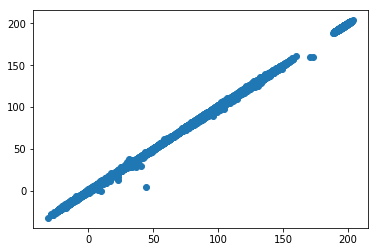

In [16]:
plt.scatter(outs[0].scalar_coupling_constant.values, df.scalar_coupling_constant.values)

# Pushout + Median Stacking
>* Pushout strategy is bit aggresive

# MinMax + Mean Stacking
>* MinMax seems more gentle and it outperforms the previous one

# MinMax + Median Stacking

## Averaging Ranks

Best Results : Stack Median

# Blending Approach